<a href="https://colab.research.google.com/github/Am1rTl/Info/blob/main/Spaceship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [ ]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)

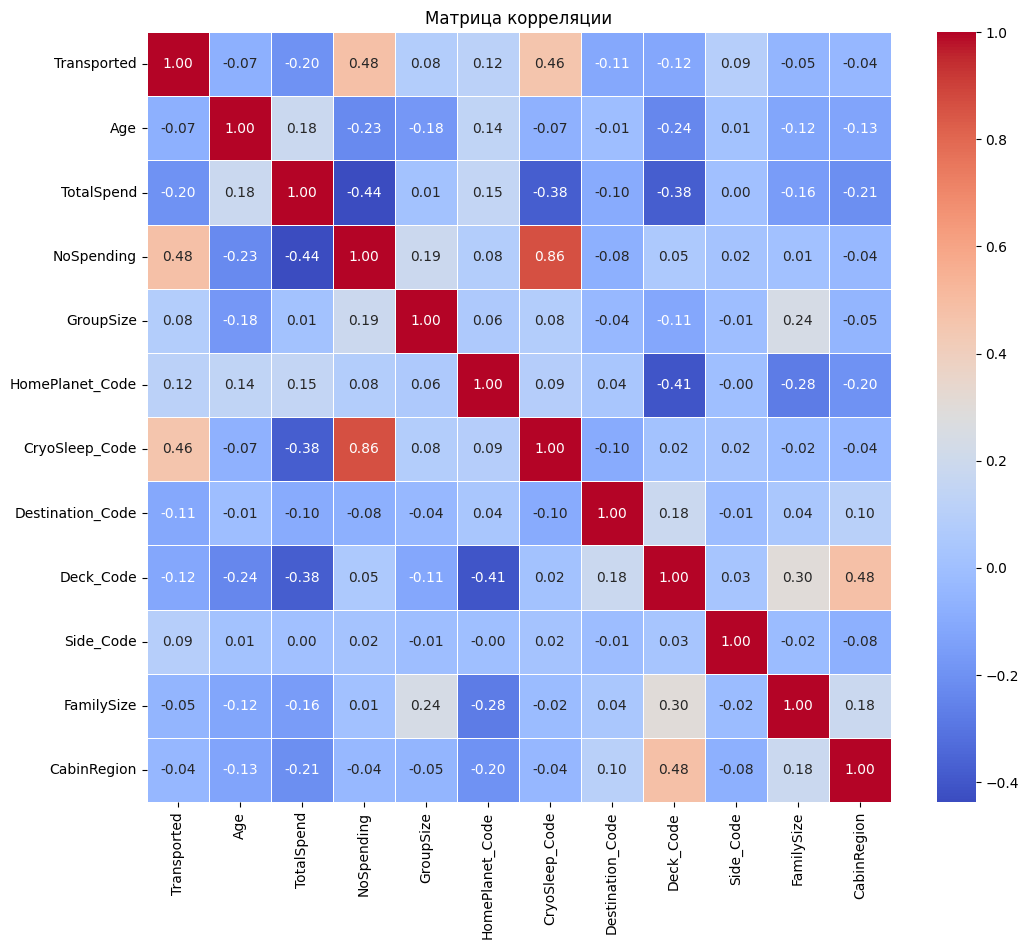

In [ ]:
corr_features = [
    'Transported', 'Age', 'TotalSpend', 'NoSpending', 'GroupSize',
    'HomePlanet_Code', 'CryoSleep_Code', 'Destination_Code',
    'Deck_Code', 'Side_Code', 'FamilySize', 'CabinRegion'
]

corr_matrix = df.iloc[:len(train)][corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Матрица корреляции")
plt.show()

In [ ]:
df['Cabin'] = df['Cabin'].fillna('Z/9999/Z')
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
df['Num'] = pd.to_numeric(df['Num'], errors='coerce')
df.loc[df['Deck'] == 'Z', ['Deck', 'Num', 'Side']] = np.nan

In [ ]:
df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
df['GroupSize'] = df['Group'].map(df['Group'].value_counts())

In [ ]:
df['CabinRegion'] = (df['Num'] // 50).fillna(-1).astype(int)
df['Deck_Side'] = df['Deck'] + "_" + df['Side']

In [ ]:
expenses = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[expenses] = df[expenses].fillna(0)
df['TotalSpend'] = df[expenses].sum(axis=1)
df['NoSpending'] = (df['TotalSpend'] == 0).astype(int)

In [ ]:
for col in expenses + ['TotalSpend']:
    df[f'Log_{col}'] = np.log1p(df[col])

In [ ]:
df['Surname'] = df['Name'].str.split().str[-1]
df['FamilySize'] = df['Surname'].map(df['Surname'].value_counts()).fillna(0)
df['IsFamily'] = (df['FamilySize'] > 1).astype(int)

# Заполнение пропусков


In [ ]:
df.loc[(df['CryoSleep'].isna()) & (df['TotalSpend'] > 0), 'CryoSleep'] = False
df.loc[df['CryoSleep'] == True, expenses] = 0

In [ ]:
group_home_map = df.groupby('Group')['HomePlanet'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['HomePlanet'] = df['HomePlanet'].fillna(df['Group'].map(group_home_map))

In [ ]:
group_deck_map = df.groupby('Group')['Deck'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['Deck'] = df['Deck'].fillna(df['Group'].map(group_deck_map))

In [ ]:
group_side_map = df.groupby('Group')['Side'].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
df['Side'] = df['Side'].fillna(df['Group'].map(group_side_map))

In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
df['VIP'] = df['VIP'].fillna(False)

/tmp/ipython-input-2876955553.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0])
/tmp/ipython-input-2876955553.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)


In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['CryoSleep'] = df['CryoSleep'].fillna(df['CryoSleep'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])
df['VIP'] = df['VIP'].fillna(False)

# финальная подготовка

In [ ]:
cat_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'Surname', 'Deck_Side']

for col in cat_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[f'{col}_Code'] = le.fit_transform(df[col])

In [ ]:
features_to_drop = ['PassengerId', 'Name', 'Cabin', 'Transported', 'Group', 'Surname', 'Deck_Side', 'HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
features = [c for c in df.columns if c not in features_to_drop]

In [ ]:
X = df.iloc[:len(train)][features]
y = df.iloc[:len(train)]['Transported'].astype(int)
X_test = df.iloc[len(train):][features]

In [ ]:
len(features)

27

# Обучение


In [ ]:
# сиды я перебрал локально и выбрал лучшие
DREAM_SEEDS = [183, 855, 789, 405, 689, 378, 559]
N_FOLDS = 5

In [ ]:
test_preds_cumulative = np.zeros(len(X_test))
oof_preds_cumulative = np.zeros(len(X))

In [ ]:
cat_params = {
    'iterations': 1200,
    'learning_rate': 0.03,
    'depth': 6,
    'l2_leaf_reg': 5,
    'verbose': 0,
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 100
}

In [ ]:
for seed in DREAM_SEEDS:
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=seed)
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostClassifier(**cat_params, random_seed=seed)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val))

        oof_preds_cumulative[val_idx] += model.predict_proba(X_val)[:, 1] / len(DREAM_SEEDS)
        test_preds_cumulative += model.predict_proba(X_test)[:, 1] / (len(DREAM_SEEDS) * N_FOLDS)

In [ ]:
final_cv = accuracy_score(y, (oof_preds_cumulative > 0.5).astype(int))
print(f"CV SCORE: {final_cv:.5f}")

CV SCORE: 0.81456


In [ ]:
submission['Transported'] = (test_preds_cumulative > 0.5).astype(bool)
submission.to_csv('submission_elite_final.csv', index=False)